In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
import copy
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data file
#J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv : Target calibrated light curve
#J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv : Target and photometric fluxes of reference stars

caldata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv')
rawdata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv')
star_info = ascii.read('../astep/CALIB-J0600-2020.csv')
print (star_info)

epoch = rawdata['BJD']
airmass = rawdata['AIRMASS']
sky = rawdata['SKY']
star_mag = star_info['MAG']

J0600_flux = rawdata['TFLUX']
J0600_coords = [90.00316332976436, -31.007910088843165]

flux = []
for i in range(1,6):
    flux.append(rawdata['CFLUX'+str(i)])
flux = np.array(flux).T

 NB   UCAC4     MAG    XC     YC   APER
--- ---------- ----- ------ ------ ----
 C1 296-008997 12.38 2033.4 2385.8    9
 C2 296-009022 12.33 1679.0 2584.5    9
 C3 296-009008  12.7 1838.4 2160.8    9
 C4 295-008892 12.42 2051.6 1756.3    9
 C5 295-008877 13.38 2198.5 1500.5    9


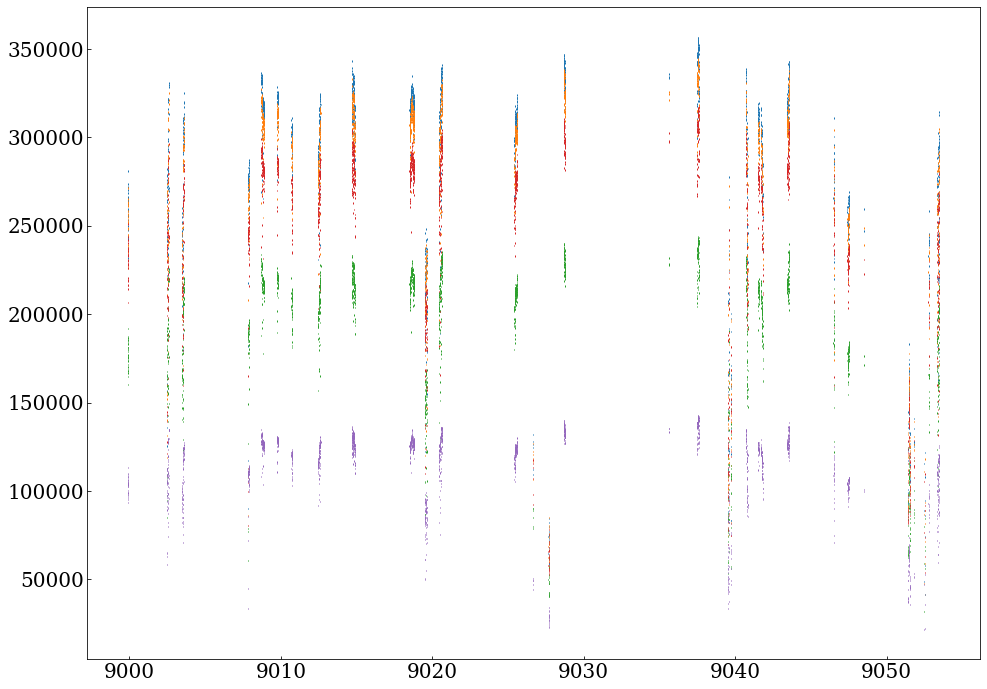

In [3]:
plt.figure(figsize=(16,12))
for s in range(5):
    plt.errorbar(epoch,flux[:,s],yerr=np.sqrt(flux[:,s]),fmt='.',markersize=0,linewidth=1)

In [4]:
star_coords_tmp = np.array([
    [6 + 19.491336/3600, -(30 + 56/60 + 22.20720/3600)],
    [6 + 45.078216/3600, -(30 + 53/60 + 13.82208/3600)],
    [6 + 33.819120/3600, -(30 + 59/60 + 50.89200/3600)],
    [6 + 18.551304/3600, -(31 +  6/60 + 11.49732/3600)],
    [6 + 08.019888/3600, -(31 + 10/60 + 11.48808/3600)]
])
star_coords = copy.copy(star_coords_tmp)
star_coords[:,0] = star_coords[:,0] /24 * 360 # from hr to degrees

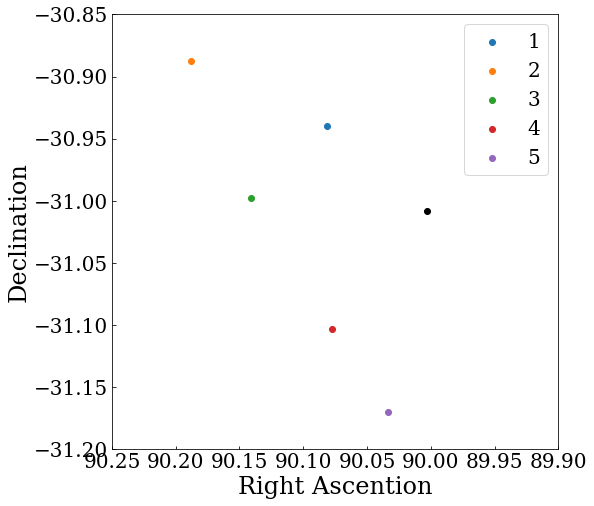

In [5]:
plt.figure(figsize=(8,8))
for s in range(5):
    plt.scatter(star_coords[s,0],star_coords[s,1],label=str(s+1))
plt.scatter([90.00316332976436], [-31.007910088843165], c='black')
plt.legend()
plt.ylim(-31.20,-30.85)
plt.xlim(90.25,89.90)
plt.xlabel("Right Ascention")
plt.ylabel("Declination")
plt.show()

# Trying the differential photometry atmospheric correction

In [16]:
# Let's skip this first two steps


In [17]:
initialw = np.nanmedian(flux,axis=0)
print (initialw)
    
def ALC_func(F,ep, inw, w):
    tmp = []
    
    for e in range(len(ep)):
        noNaN = np.isnan(F[e]) == False
        ALC_i = np.sum(((F[e]*w)/(inw))[noNaN]) / np.sum(w[noNaN])
        tmp.append(ALC_i)
        
    return np.array(tmp)

ALC = ALC_func(flux,epoch, initialw, initialw)
print (ALC)

[302707.2 293392.5 207422.5 269549.1 120918.5]
[0.82060919 0.86873054 0.88722433 ... 0.98653004 0.73664708 1.03551094]


In [18]:
def weight_func(F, ep, inw, ALC):
    
    w_ij = []
    for e in range(len(ep)):
        w_j = ((F[e]/inw) *(1/(ALC[e])))
        w_ij.append(w_j)
    w_ij = np.array(w_ij)
    
    return (1/np.sqrt(np.nanmean((w_ij-np.nanmean(w_ij,axis=0))**2,axis=0)))**2 

#neww = {}
#for f in filt:
#    neww[f] = weight_func(newflux[f],corepoch[f],initialw[f],ALC[f])

In [19]:
i = 0

test = []

while i < 60:
    i += 1
    
    neww = weight_func(flux,epoch,initialw,ALC)
    test.append(neww)
    
    ALC = ALC_func(flux,epoch, initialw, neww)
    


In [20]:
def RMS(arr):
    return np.sqrt(np.nanmean((np.nanmean(arr)-arr)**2))

In [21]:
tmp = []
for s in range(5):
    tmp.append(RMS(flux[:,s]/ALC))
print (np.array(tmp))
print (np.shape(np.array(tmp)))

[1785.31571495 2076.68547276 1619.10963574 1789.97540941 1561.05374362]
(5,)


In [23]:
# Check if wights converge within 1e-5


#for i in range(1,50):
#    plt.plot(np.array(test[i-1])-np.array(test[i]))
    #plt.yscale('log')
#plt.ylim([-1e-5,1e-5])
#    plt.show()


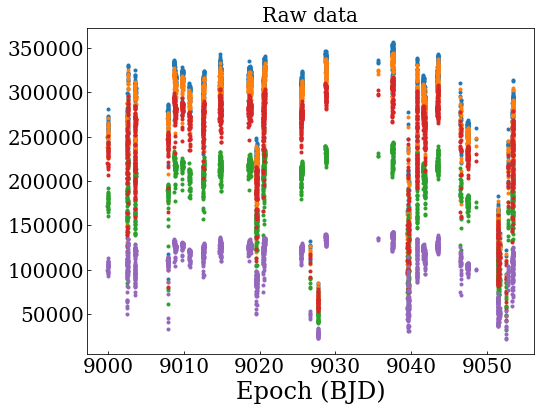

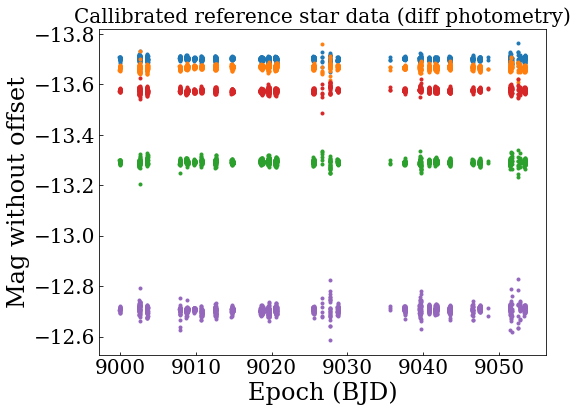

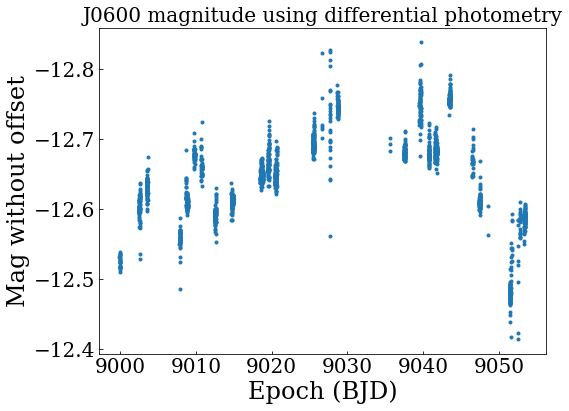

In [24]:
for s in range(5):
    plt.errorbar(epoch,flux[:,s],fmt='.')
#plt.gca().invert_yaxis()
plt.title("Raw data")
plt.xlabel("Epoch (BJD)")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10(flux[:,s]/ALC),fmt='.')
    
plt.gca().invert_yaxis()
plt.title("Callibrated reference star data (diff photometry)")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC),fmt='.')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

In [25]:
stdcl_mask = []

double_normalised_flux = (((flux.T)/ALC).T)/np.nanmedian((((flux.T)/ALC).T),axis=0)
sig = np.nanstd(double_normalised_flux,axis=1)
med = np.nanmedian(double_normalised_flux,axis=1)

print (sig)
print (med)

sigcl_flux = copy.deepcopy(flux)
#sigcl_fluxerr = copy.deepcopy(fluxerr)
for e in range(len(epoch)):
    sigclip_mask = np.abs(double_normalised_flux[e]-med[e]) > 1.5*sig[e]
    sigcl_flux[e][sigclip_mask] = np.NaN
    #sigcl_fluxerr[e][sigclip_mask] = np.NaN
print (np.sum(np.isnan(flux),axis=0))
print (np.shape(flux))
print (np.sum(np.isnan(sigcl_flux),axis=0))

[0.0057433  0.00634048 0.0090448  ... 0.00678183 0.00881676 0.00286048]
[0.99750965 0.99959271 1.00659228 ... 1.0002478  0.99407811 1.00168633]
[0 0 0 0 0]
(1933, 5)
[270 338 360 316 606]


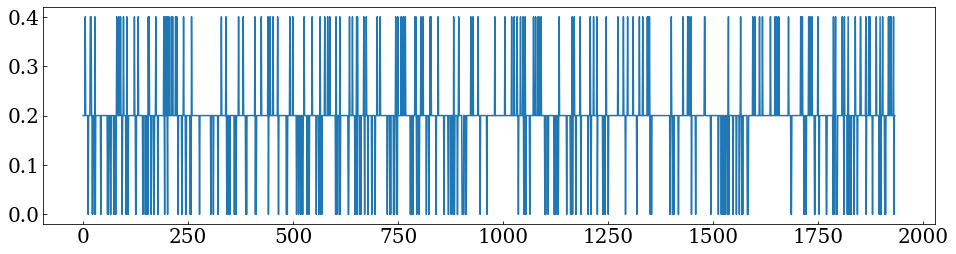

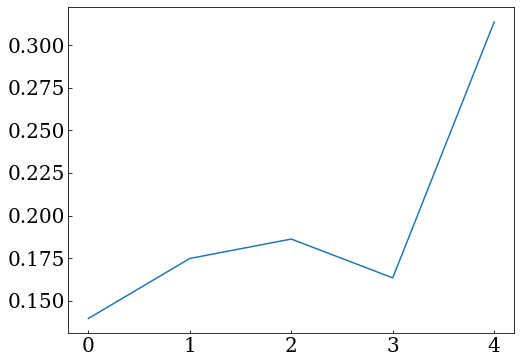

In [26]:
plt.figure(figsize=(16,4))
plt.plot(np.sum(np.isnan(sigcl_flux),axis=1)/5)
plt.show()
plt.plot(np.sum(np.isnan(sigcl_flux),axis=0)/len(epoch))
plt.show()

In [27]:
medflux2 = np.nanmedian(sigcl_flux,axis=0)
final_weight = copy.copy(neww)
print (medflux2)

[303802.8 294323.2 207917.6 269187.2 120577.4]


In [28]:
ALC_final = {}

i = 0

test = []

while i < 40:
    i += 1
    
    ALC_final = ALC_func(sigcl_flux, epoch, medflux2, final_weight)


    final_weight = weight_func(sigcl_flux, epoch, medflux2, ALC_final)
    test.append(final_weight)

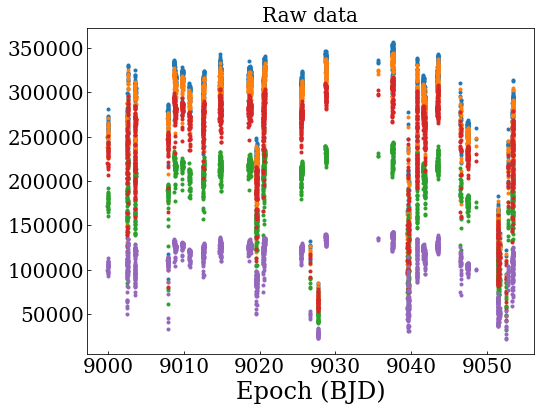

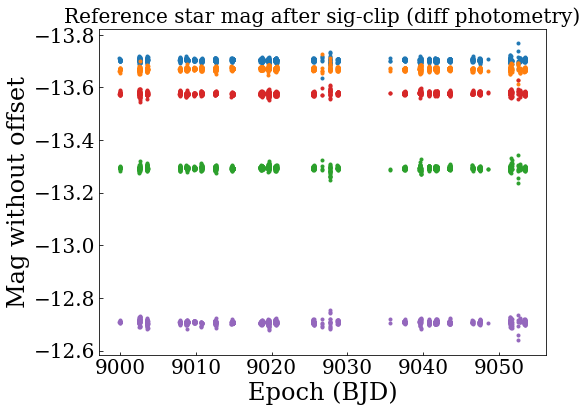

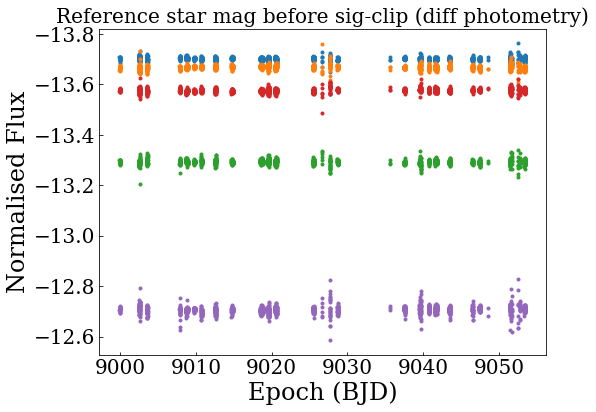

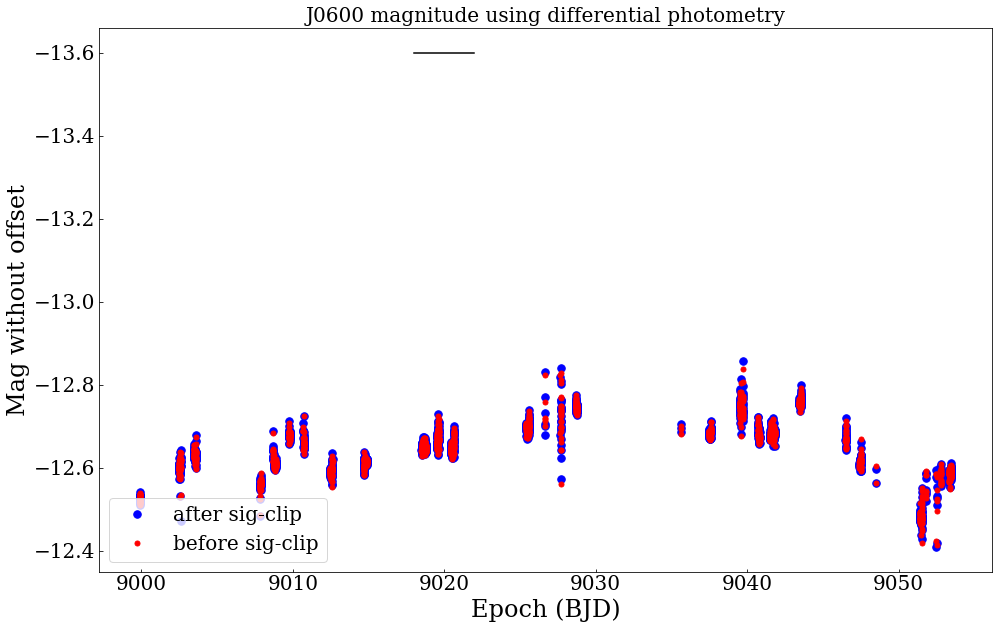

In [36]:
for s in range(5):
    plt.errorbar(epoch,flux[:,s],fmt='.')
#plt.gca().invert_yaxis()
plt.title("Raw data")
plt.xlabel("Epoch (BJD)")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10((sigcl_flux[:,s]/ALC_final)),fmt='.')
plt.gca().invert_yaxis()
plt.title("Reference star mag after sig-clip (diff photometry)")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10((flux[:,s]/ALC)),fmt='.')   
plt.gca().invert_yaxis()
plt.title("Reference star mag before sig-clip (diff photometry)")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Normalised Flux")
plt.show()

plt.figure(figsize=(16,10))
plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC_final),fmt='.',c='b',markersize=15,label='after sig-clip')
plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC),fmt='.',c='r',markersize=10, label='before sig-clip')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.legend(loc=3)
#plt.xlim(9018,9022)
plt.plot([9018,9022],[-13.6]*2,c='black')
plt.show()
#plt.gca().invert_yaxis()
#plt.title("J0600 magnitude using differential photometry")
#plt.xlabel("Epoch (BJD)")
#plt.ylabel("Mag without offset")
#plt.show()

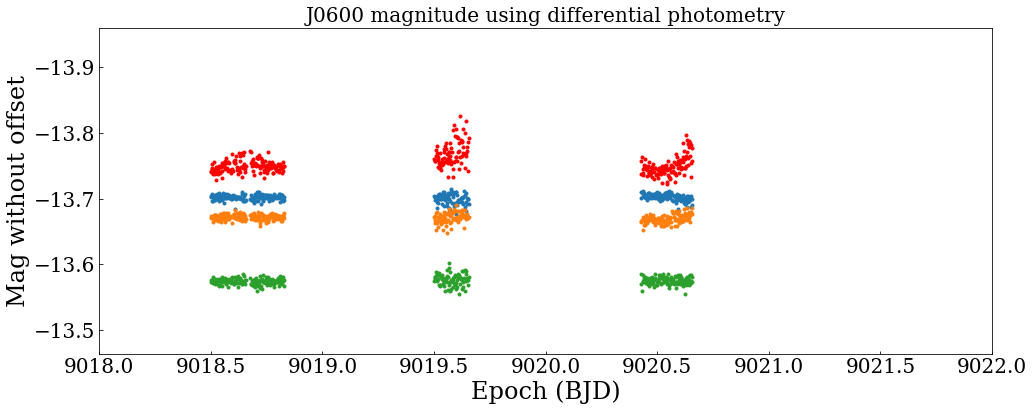

In [101]:
plt.figure(figsize=(16,6))
for s in [0,1,3]:
    plt.errorbar(epoch,-2.5*np.log10((flux[:,s]/ALC)),fmt='.',label=s)   
plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC)-1.1,fmt='.',c='r')#,markersize=10, label='before sig-clip')
plt.gca().invert_yaxis()
plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.xlim(9018,9022)
#plt.legend()
#plt.xlim(9024,9030)
l = 5*2
#plt.xlim(8995+l,9000+l)
plt.show()

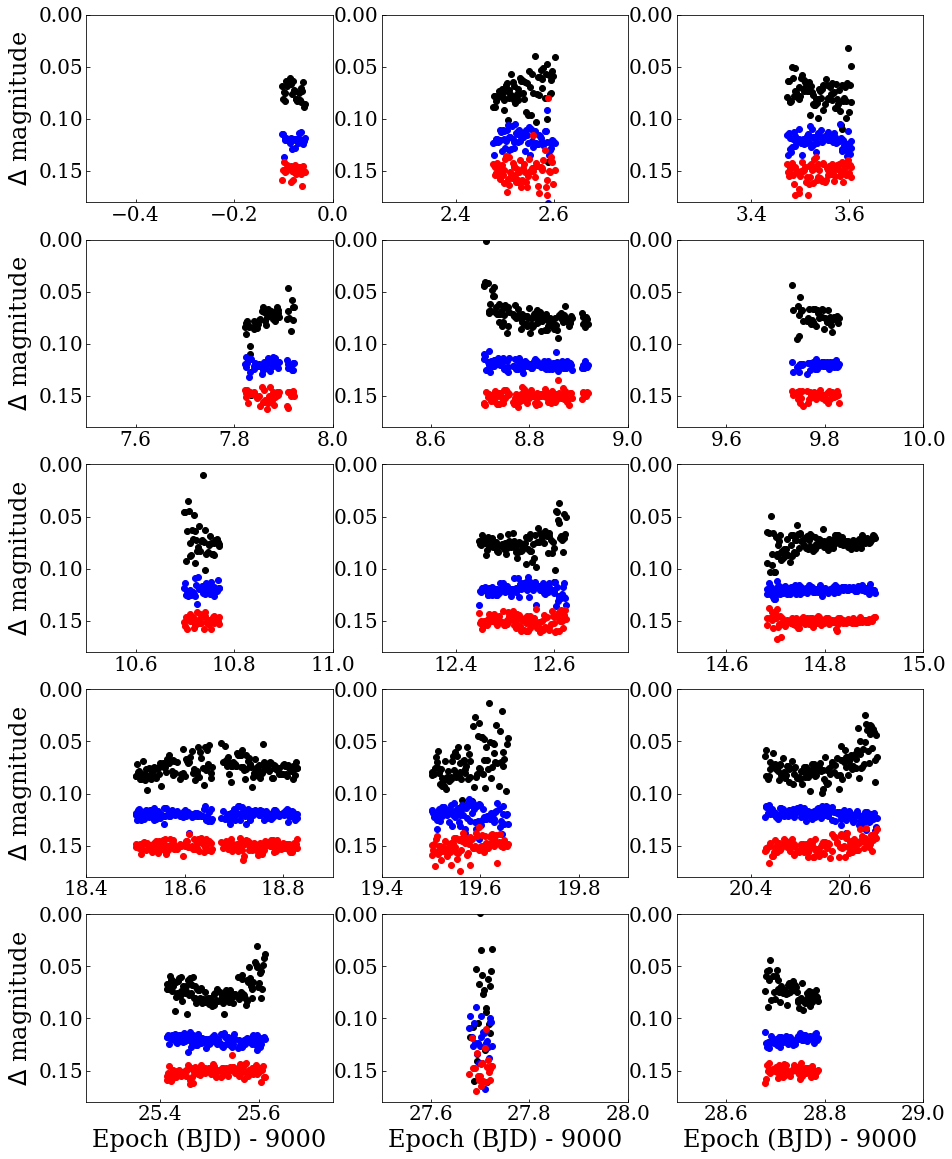

In [144]:
i_lim = 5
j_lim = 3
fig, axs = plt.subplots(i_lim,j_lim)
fig.set_figheight(4*i_lim)
fig.set_figwidth(5*j_lim)

lims = np.array([
    [[-0.5,  0],     [2.25,  2.75],  [3.25, 3.75]],
    [[7.5,   8],     [8.5,   9],     [9.5,  10]],
    [[10.5,  11],    [12.25, 12.75], [14.5, 15]],
    [[18.4,  18.9],  [19.4,  19.9],    [20.25, 20.75]],
    [[25.25, 25.75], [27.5,  28],    [28.5, 29]]
])

def windowplt(i,j,x,y,offset,c,mask):
    axs[i,j].errorbar(x,-2.5*np.log10(y) - np.nanmedian(-2.5*np.log10(y[mask])) + offset, fmt='o',c=c)

for i in range(i_lim):
    for j in range(j_lim):
        m1 = epoch-9000 > lims[i,j,0]
        m2 = epoch-9000 < lims[i,j,1]
        windowplt(i,j, epoch-9000, J0600_flux/ALC, 0.075, 'black', m1*m2)
        s = 0
        windowplt(i,j, epoch-9000, flux[:,s]/ALC, 0.12, 'blue', m1*m2)
        s = 1
        windowplt(i,j, epoch-9000, flux[:,s]/ALC, 0.15, 'red', m1*m2)
        
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC))[m1*m2])+0.03,
        #         marker='.',linestyle='',markersize=10,c='r')
        #s = 0
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.08,
        #         marker='.',linestyle='',markersize=10,c='blue')
        #s = 1
        #axs[i,j].plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.12,
        #         marker='.',linestyle='',markersize=10,c='orange')
        
        axs[i,j].set_xlim(lims[i,j])
        axs[i,j].set_ylim([0,0.18])
        #axs[i,j].set_ylim([-0.05,0.35])
        axs[i,j].invert_yaxis()
        
        if j == 0:
            axs[i,j].set_ylabel('$\Delta$ magnitude')
        if i == i_lim-1:
            axs[i,j].set_xlabel('Epoch (BJD) - 9000')

#for ax in axs.flat:
#    ax.set(xlabel='Epoch (BJD)', ylabel='$\Delta$ magnitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

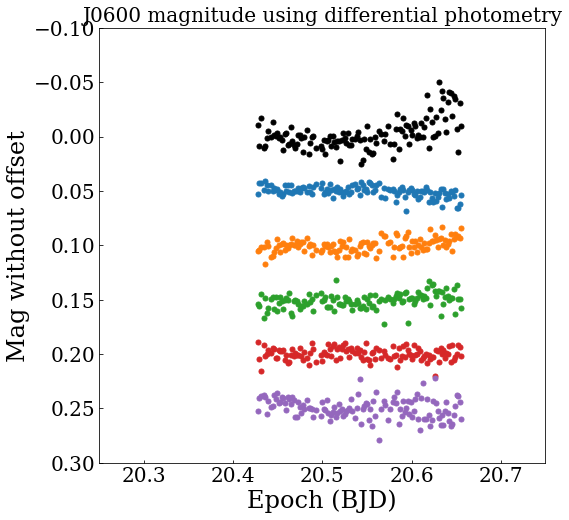

In [126]:
i,j = 3,2

m1 = epoch-9000 > lims[i,j,0]
m2 = epoch-9000 < lims[i,j,1]

plt.figure(figsize=(8,8))
plt.plot(epoch-9000,-2.5*np.log10(J0600_flux/ALC)-np.nanmedian((-2.5*np.log10(J0600_flux/ALC))[m1*m2]),
                 marker='.',linestyle='',markersize=10,c='black')
for s in range(5):#[0,1,3]:
    plt.plot(epoch-9000,-2.5*np.log10(flux[:,s]/ALC)-np.nanmedian((-2.5*np.log10(flux[:,s]/ALC))[m1*m2])+0.05*(s+1),
                 marker='.',linestyle='',markersize=10)

plt.title("J0600 magnitude using differential photometry")
plt.xlabel("Epoch (BJD)")
plt.ylabel("Mag without offset")
plt.xlim(lims[i,j])
plt.ylim(-0.1,0.3)
plt.gca().invert_yaxis()
plt.show()

# Merge datapoints that are taken close together for higher accuracy

1286.320463999975


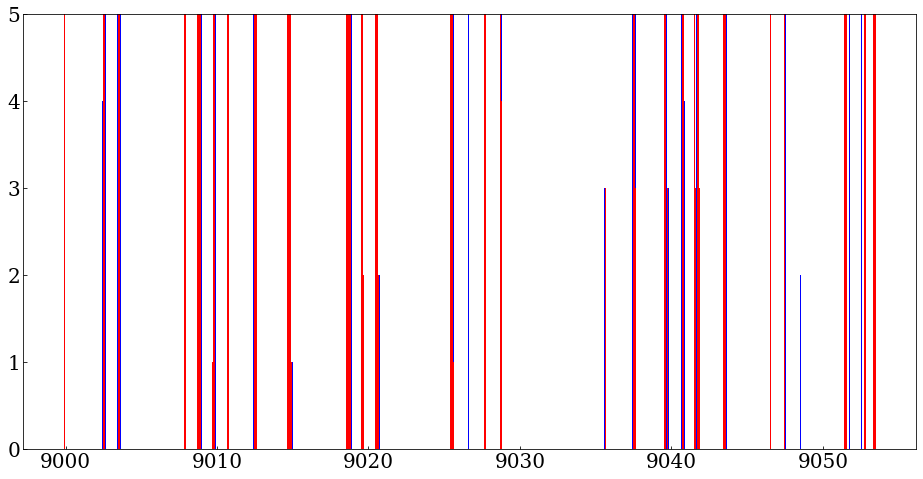

In [47]:
print ((np.max(epoch)-np.min(epoch))*24)
plt.figure(figsize=(16,8))
#plt.hist(epoch,bins=60)
#plt.hist(epoch,bins=300)
plt.hist(epoch,bins=int(((np.max(epoch)-np.min(epoch))*12)),color='blue') #bins of an hour
plt.hist(epoch,bins=int(((np.max(epoch)-np.min(epoch))*24)),color='red') #bins of an hour
#plt.ylim(0,5)
plt.show()